# **Deep Learning for Stock Prices**
#### Using Long Short-Term Memory 
---

### Import Dependencies 

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from alpha_vantage.timeseries import TimeSeries 

print("All Libraries Loaded")

All Libraries Loaded


### Configure Basic Parameters 

In [2]:
config = {
    "alpha_vantage": {
        "key": "ALPHA_VANTAGE_API_KEY", 
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # only using close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", 
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

### Download Data

In [5]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

In [6]:
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5624 from 1999-11-01 to 2022-03-08


### Plot

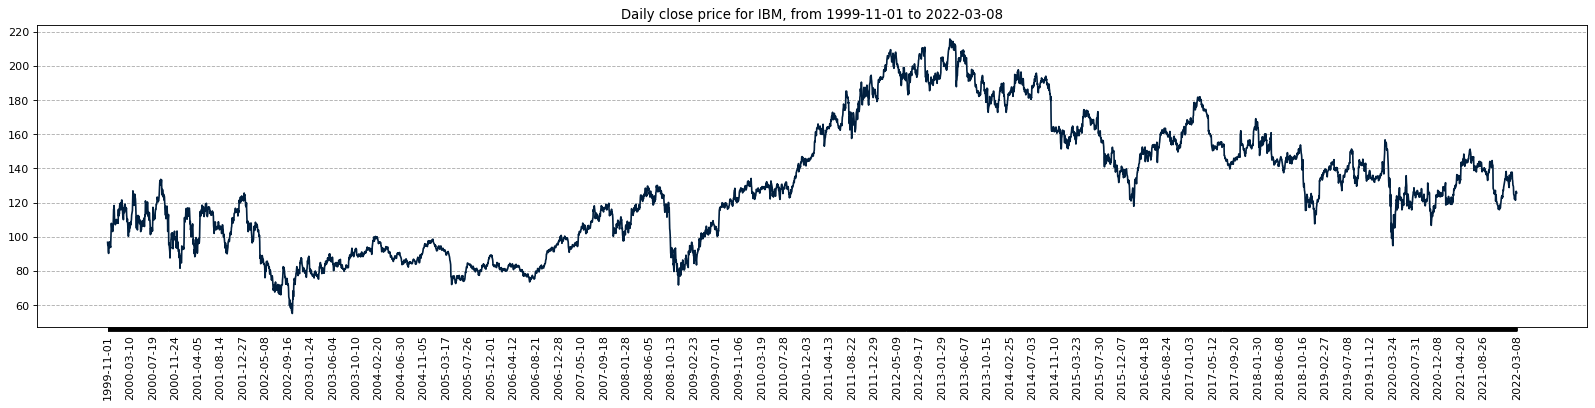

In [7]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])


xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 
                            and (num_data_points-i) > config["plots"]["xticks_interval"]) 
                           or i==num_data_points-1) 
          else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))


plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

### Normalization 

In [8]:
class Normalizer():
    def __init__(self):
        self.mu = None # mean
        self.sd = None # standard deviation 

    def fit_transform(self, x):
        # keepdims keeps output the way we want it 
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

In [9]:
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

---
# Data Preparation: Generate Training and Validation Data Sets 
---

### Prepare Data

In [10]:
# shape of x = (number of rows, sequence of prices)
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

# shape of y = (number of rows, )
def prepare_data_y(x, window_size):
    # Simple Moving Average 
    # np.convolve(one-dimensional input, second one-dimensional input, mode='valid')
    # valid: returns output of the length
    # returns linear convolution of two one-dimensional arrays 
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size    
    
    # move window size over one so different than training data 
    output = x[window_size:]
    return output

In [11]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

### Split Dataset

In [12]:
split_index = int(data_y.shape[0]*config["data"]["train_split_size"])

data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]

data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

### Prepare Data for Plotting

In [13]:
# np.zeros(shape) -> returns new aray of given shape and type with zeros 
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

# inverse transform -> insert X values into applicable ranges
to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

# np.where(condition,when true,when false) -> returns ndarray or tuple of ndarrays 
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

### Plot 

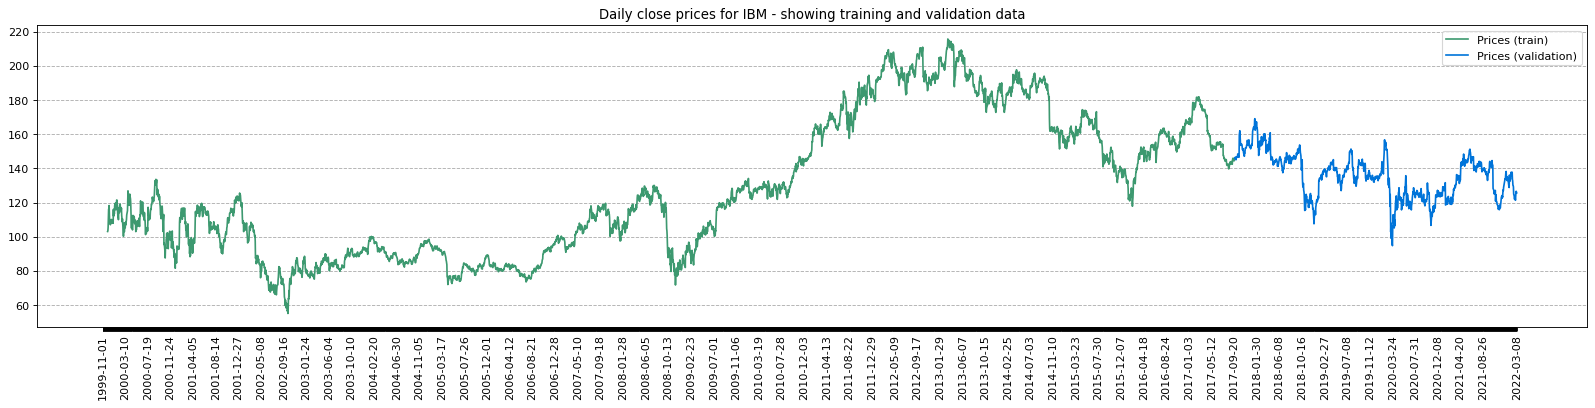

In [14]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))


plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])


xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 
                            and (num_data_points-i) > config["plots"]["xticks_interval"]) 
                           or i==num_data_points-1) 
          else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))


plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

---
## Clean ^^ 
---